In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import time
from operator import add
import tensorflow as tf
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
#%pip install matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import (
    jaccard_score, f1_score, recall_score, precision_score, accuracy_score, fbeta_score)

from utils import create_dir, load_model_file
from data import load_data

Note: you may need to restart the kernel to use updated packages.


In [2]:
""" Hyperparameters """
size = (256, 256)
input_shape = (256, 256, 3)
model_name = "A"
model_path = f"files/{model_name}/model.h5"


In [3]:
""" Directories """
create_dir(f"results/{model_name}")

""" Load the model """
model = load_model_file(model_path)

""" Sample prediction: To improve FPS """
image = np.zeros((1, 256, 256, 3))
mask = model.predict(image)

1/1 [==============================] - 3s 3s/step


In [4]:
dir_path = os.path.join(".", "results", model_name, "masks")
if not os.path.exists(dir_path):
    os.makedirs(dir_path)


In [5]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


In [6]:
path = "../../Dataset/Kvasir-SEG/"
name = "cju0qkwl35piu0993l0dewei2"
image_fn = os.path.join(path, "images/cju0qkwl35piu0993l0dewei2.jpg")
mask_fn = os.path.join(path, "masks/cju0qkwl35piu0993l0dewei2.jpg")

print (image_fn)
print (mask_fn)


../../Dataset/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg
../../Dataset/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg


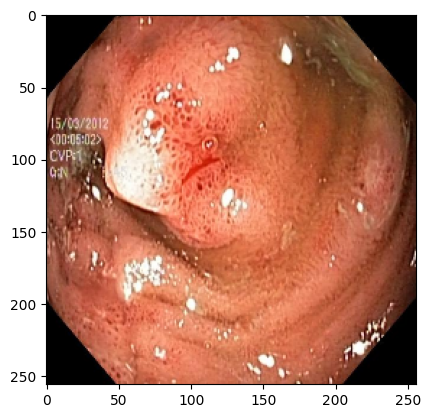

In [8]:
""" Image """
image = cv2.imread(image_fn, cv2.IMREAD_COLOR)
image = cv2.resize(image, size)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
ori_img = image
image = image/255.0
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)

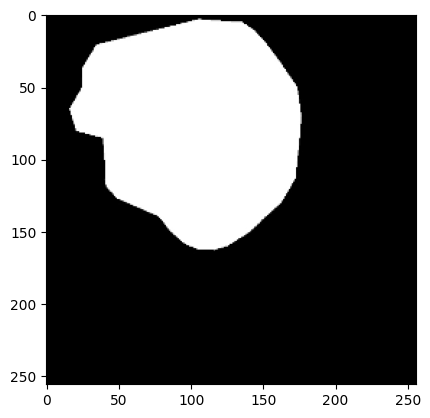

In [11]:
""" Mask """
mask = cv2.imread(mask_fn, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, size)
plt.imshow(mask, cmap="gray")
ori_mask = mask
mask = np.expand_dims(mask, axis=0)
mask = mask/255.0
mask = mask.astype(np.float32)


In [12]:
""" Time taken """
time_taken = []
start_time = time.time()
pred_y = model.predict(image)
total_time = time.time() - start_time
time_taken.append(total_time)
print(f"{image_fn}: {total_time:1.5f}")

1/1 [==============================] - 0s 74ms/step
../../Dataset/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg: 0.18000


In [13]:
""" Saving masks """
pred_y_saved = pred_y
pred_y = pred_y[0] > 0.5
pred_y = pred_y * 255

pred_y = np.array(pred_y, dtype=np.uint8)


In [14]:
ori_img = ori_img
ori_mask = mask_parse(ori_mask)
pred_y = mask_parse(pred_y)
sep_line = np.ones((size[0], 10, 3)) * 255

tmp = [
    ori_img, sep_line,
    ori_mask, sep_line,
    pred_y
]


In [16]:
cat_images = np.concatenate(tmp, axis=1)
fnn = os.path.join(".", "results", model_name, f"{name}.png")
print("Write to file name", fnn)
try:
    success = cv2.imwrite(fnn, cat_images)
    if not success:
        raise Exception(f"Could not write image to {fnn}")
except Exception as e:
    print(f"Exception occurred: {e}")

Write to file name .\results\A\cju0qkwl35piu0993l0dewei2.png


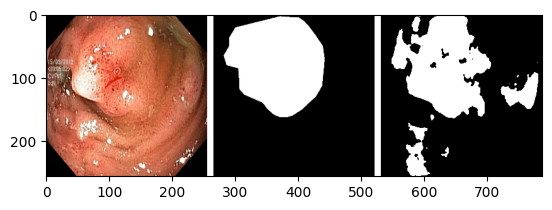

In [19]:
if cat_images.dtype != np.uint8:
    # Normalize if the array is in float format and convert to np.uint8
    if cat_images.dtype == np.float32 or cat_images.dtype == np.float64:
        # Normalize to 0-255 if it's in 0-1 range
        if cat_images.max() <= 1.0:
            cat_images = cat_images * 255
    # Convert to np.uint8
    cat_images = cat_images.astype(np.uint8)

# Convert BGR to RGB for display
cat_images_rgb = cv2.cvtColor(cat_images, cv2.COLOR_BGR2RGB)
plt.imshow(cat_images_rgb)


In [20]:
# Assuming pred_y is a binary mask after thresholding
# and ori_img is the original image read with cv2.IMREAD_COLOR

# Ensure pred_y_saved is a binary mask with values 0 or 1
pred_y_saved = pred_y_saved[0] > 0.5

# Convert the binary mask to uint8 type and scale it to the range [0, 255]
pred_y_saved = np.array(pred_y_saved, dtype=np.uint8) * 255

# Create an RGBA image with the original image and an alpha channel
ori_img_rgba = cv2.cvtColor(ori_img, cv2.COLOR_BGR2BGRA)

# Choose a color for the mask, e.g., yellow (BGR format)
mask_color = [0, 255, 255, 128]  # BGR format for yellow and 128 for alpha (semi-transparent)

# Create a colored mask with the same size as the original image
colored_mask = np.zeros_like(ori_img_rgba, dtype=np.uint8)

# Apply the mask color only to the areas where pred_y_saved is True
mask_indices = np.where(pred_y_saved == 255)
colored_mask[mask_indices[0], mask_indices[1], :3] = mask_color[:3]  # Apply color to the mask area
colored_mask[mask_indices[0], mask_indices[1], 3] = mask_color[3]    # Apply alpha to the mask area


Write to file name results\A\cju0qkwl35piu0993l0dewei2_overlay.png


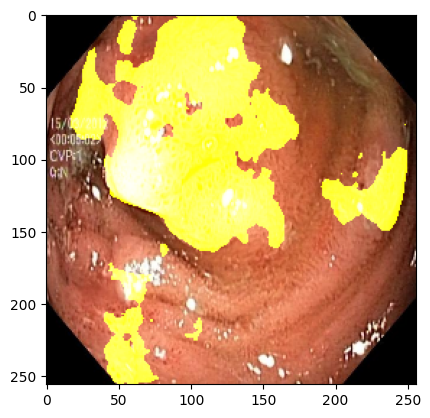

In [22]:
# Superimpose the mask onto the original image
superimposed_img = cv2.addWeighted(colored_mask, 1, ori_img_rgba, 1, 0)
# Save the superimposed image to a file
output_filename = f"{name}_overlay.png"
output_filepath = os.path.join("results", model_name, output_filename)
print("Write to file name", output_filepath)
cv2.imwrite(output_filepath, superimposed_img)
rgb_image = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)
